# LSTM Plus Attention

In [1]:
from keras.engine.topology import Layer

class EatMask(Layer):
    def __init__(self, **kwargs):
        super(EatMask, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return x

    def get_output_shape_for(self, input_shape):
        return input_shape
    
    def compute_mask(self, x, mask):
        return None

Using Theano backend.


In [17]:
from keras.layers import Input, Embedding, Dense, SimpleRNN, merge, Activation, Permute, Reshape, Lambda
from keras.layers import Convolution1D, MaxPooling1D, Flatten, TimeDistributed, RepeatVector
from keras.layers.convolutional import AveragePooling1D
from keras.models import Model

max_doclen = 12
word_dim, vocab_size = 5, 10

nb_class = 2

input = Input(shape=[max_doclen], dtype='int32')

# embedding
embedded = Embedding(output_dim=word_dim,
                     input_dim=vocab_size,
                     input_length=max_doclen,
                     mask_zero=True,
                     weights=None)(input)

# lstm the document
activations = SimpleRNN(16, return_sequences=True, name='activations')(embedded)
activations = EatMask()(activations)

# attention mask
mask = TimeDistributed(Dense(1), name='td')(activations)
mask = Reshape([max_doclen])(mask)
mask = Activation('softmax', name='softmax')(mask)
mask = RepeatVector(16)(mask)
mask = Permute([2, 1])(mask)

# apply mask
activations = merge([activations, mask], mode='mul')
activations = AveragePooling1D(pool_length=max_doclen)(activations)
activations = Flatten()(activations)

probas = Dense(nb_class, activation='softmax')(activations)

# compile
model = Model(input=input, output=probas)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 12)            0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 12, 5)         50          input_6[0][0]                    
____________________________________________________________________________________________________
activations (SimpleRNN)          (None, 12, 16)        352         embedding_5[0][0]                
____________________________________________________________________________________________________
eatmask_5 (EatMask)              (None, 12, 16)        0           activations[0][0]                
___________________________________________________________________________________________

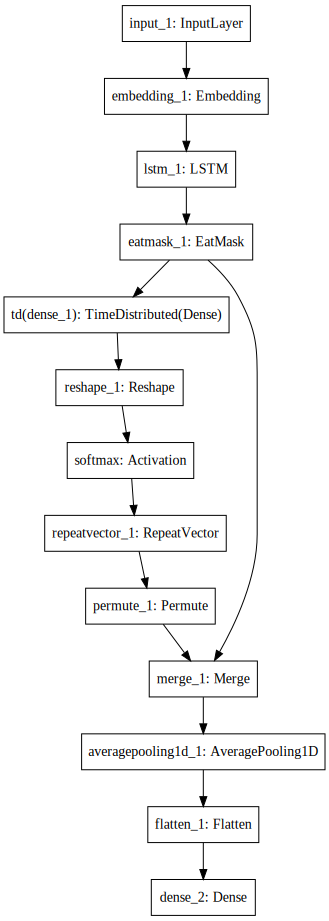

In [3]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [4]:
from keras.utils.np_utils import to_categorical

X_train = np.array([[0, 0, 0, 2, 4, 2, 3, 1, 2, 3, 2, 1],
                    [0, 2, 1, 2, 4, 2, 3, 1, 2, 3, 2, 1]])
y = to_categorical([1, 0])

# model.fit(X_train, y)

In [20]:
import keras.backend as K

f = K.function(inputs=model.inputs, outputs=[model.get_layer('activations').output, model.get_layer('softmax').output])

In [21]:
f([X_train])

[array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [-0.03216095,  0.00667053, -0.01970632,  0.01463582,  0.0255296 ,
          -0.01704883,  0.0106651 , -0.02896355,  0.02593829,  0.03794508,
           0.01217334, -0.03668317,  0.01834284, -0.02639282,  0.03017639,
           0.00420537],
    

In [11]:
model.get_layer('activations').b.eval()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [13]:
import theano.tensor as T

In [29]:
X = T.dmatrix(name='X')

In [30]:
exp_X = T.exp(X)

In [31]:
import theano

In [38]:
f = theano.function(inputs=[X], outputs=exp_X)

In [40]:
f([np.random.randn(1, 5)])

TypeError: Too many parameter passed to theano function

In [61]:
T.max?

In [58]:
T.exp?

In [59]:
T.sum?

In [81]:
ones = np.ones([2, 1])

In [84]:
zeros = np.zeros([2, 1])

In [85]:
import theano
import theano.tensor as T

x = T.dmatrix('x')
x -= T.max(x, axis=0, keepdims=True)
e_x = T.exp(x)
sum_x = T.sum(e_x, axis=0, keepdims=True)
s_x = e_x / sum_x

f = theano.function(inputs=[x], outputs=[x, e_x, sum_x, s_x])
x, e_x, sum_x, s_x = f([ones, zeros])

TypeError: Bad input argument to theano function with name "<ipython-input-85-04e57bbfad06>:10" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-04e57bbfad06>", line 5, in <module>
    x -= T.max(x, axis=0, keepdims=True)
Wrong number of dimensions: expected 2, got 3 with shape (2, 2, 1).

In [129]:
np.array([1, 2])[:, np.newaxis]

array([[1],
       [2]])

In [134]:
import theano
import theano.tensor as T

x = T.tensor3('x')
m_x = T.max(x, axis=1, keepdims=True)
s_x = x - m_x
e_x = T.exp(s_x)
sum_x = T.sum(e_x, axis=1, keepdims=True)
sm_x = e_x / sum_x

f = theano.function(inputs=[x], outputs=[x, m_x, s_x, e_x, sum_x, sm_x])
x, m_x, s_x, e_x, sum_x, sm_x = f([np.array([[1], [2]]), zeros])

In [141]:
x.shape

(2, 2, 1)

In [136]:
m_x

array([[[ 2.]],

       [[ 0.]]], dtype=float32)

In [137]:
s_x

array([[[-1.],
        [ 0.]],

       [[ 0.],
        [ 0.]]], dtype=float32)

In [138]:
e_x

array([[[ 0.36787945],
        [ 1.        ]],

       [[ 1.        ],
        [ 1.        ]]], dtype=float32)

In [139]:
sum_x

array([[[ 1.36787939]],

       [[ 2.        ]]], dtype=float32)

In [140]:
sm_x

array([[[ 0.26894143],
        [ 0.7310586 ]],

       [[ 0.5       ],
        [ 0.5       ]]], dtype=float32)

In [106]:
np.ones([2, 3, 4])

array([[[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]]])

In [109]:
np.ones([2, 3, 4]).sum(axis=1, keepdims=True)

array([[[ 3.,  3.,  3.,  3.]],

       [[ 3.,  3.,  3.,  3.]]])

In [103]:
np.ones([3, 4, 5]).sum(axis=1)

array([[ 4.,  4.,  4.,  4.,  4.],
       [ 4.,  4.,  4.,  4.,  4.],
       [ 4.,  4.,  4.,  4.,  4.]])